# About Dataset

Data source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data?select=Clean_Dataset.csv

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset.

Description:
* `Date`: The date when tickets are available
* `Airline:` The name of the airline company is stored in the airline column. It is a categorical feature having 8 different airlines.
* `Flight:` Flight stores information regarding the plane's flight code. It is a categorical feature.
* `Source City:` City from which the flight takes off. It is a categorical feature having 6 unique cities.
* `Departure Time:` This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
* `Stop:` A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
* `Arrival Time:` This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
* `Destination City:` City where the flight will land. It is a categorical feature having 6 unique cities.
* `Class:` A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
* `Duration:` A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
* `Days Left:` This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
* `Price:` Target variable stores information of the ticket price.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp
from scipy.stats import randint, uniform

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

In [2]:
# Models Library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #gud
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet #gud
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR #gud
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
# ==========  Non-Linear Regressor  ==========================
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

- Spearman correlation between these numerical variables are below 0.5 or -0.5, but we can lower our threshold for these correlation to 0.2 and -0.2 since the data was complex.

# Data Transformation

In [48]:
def transform(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [49]:
# Transform the data
df_cleaned = transform(df)

# Drop flight code and trip columns
df_cleaned.drop(['flight', 'ch_code', 'num_code', 'trip'], axis=1, inplace=True)

# Check duplicates after transformation
print('Duplicates:', df_cleaned[df_cleaned.duplicated()].shape[0])
df_cleaned = df_cleaned[~df_cleaned.duplicated()]
df_cleaned = df_cleaned.reset_index(drop=True)
print('Cleaned Dataset Shape:', df_cleaned.shape)
df_cleaned.tail()

Duplicates: 2213
Cleaned Dataset Shape: (295707, 35)


,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,departure_time_Afternoon,departure_time_Evening,departure_time_Night,departure_time_Late_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
295702,1.0,1,10.08,49,69265,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295703,1.0,1,10.42,49,77105,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295704,1.0,1,13.83,49,79099,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295705,1.0,1,10.00,49,81585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295706,1.0,1,10.08,49,81585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
# Save the cleaned dataset
df_cleaned.to_csv('Dataset_Transformed.csv', index=True)

# Modeling

In [51]:
# Define the features and target
x = df_cleaned.drop(['price'], axis=1)
y = df_cleaned['price']

# joblib.dump(x.columns, 'feature_name.joblib')

### Linear Regression

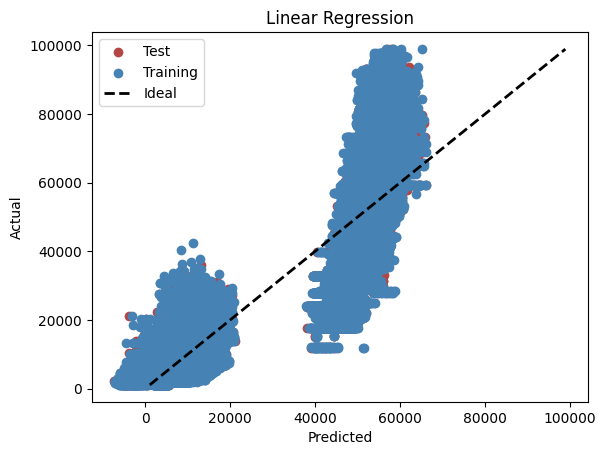

Linear Regression - Test Set Evaluation Metrics:
MAPE: 0.4274010679130761
MAE : 4482.0243312705015
MSE : 45387648.41511954
RMSE: 6737.035580663022
R^2 : 0.9115648106528835



In [52]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_lr.joblib')

model = LinearRegression()

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title(f'Linear Regression')
plt.show()

# Print metrics
print(f"Linear Regression - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}\n")

# Save the model
# joblib.dump(model, f'model_lr.joblib')

### Polynomial Regression

In [53]:
# Add Polynomial Features
degree = 2
poly = PolynomialFeatures(degree=degree)

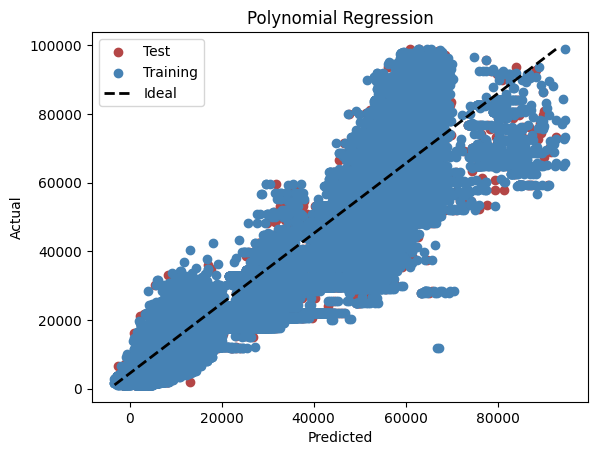

Polynomial Regression - Test Set Evaluation Metrics:
MAPE: 0.2788387162188757
MAE : 3235.5749890095026
MSE : 24903829.131716885
RMSE: 4990.3736465035245
R^2 : 0.9514763394527846


In [54]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_poly.joblib')

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
# joblib.dump(poly, 'poly.joblib')

model = LinearRegression()

model.fit(x_train_poly, y_train)

y_train_pred = model.predict(x_train_poly)
y_test_pred = model.predict(x_test_poly)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('Polynomial Regression')
plt.show()

# Print metrics
print("Polynomial Regression - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")
 

# Save the model
# joblib.dump(model, 'model_poly.joblib')

### Random Forest

In [55]:
# rf_params = {
#     'max_depth': [40, 60, 80],
#     'min_samples_split': [2, 5, 10],
#     'max_features': [0.8, 1],
#     'n_estimators': [400, 450, 550],
#     'random_state': [42],
#     'n_jobs': [-1]
# }

# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# # Apply Grid Search
# grid_rf_search = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, n_jobs=-1, verbose=3)
# grid_rf_search.fit(x_train, y_train)
# print('Best Params:', grid_rf_search.best_params_)
# print('Best Score:', grid_rf_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Params: {'max_depth': 60, 'max_features': 0.8, 'min_samples_split': 10, 'n_estimators': 550, 'n_jobs': -1, 'random_state': 42}
Best Score: 0.9865099331293207


In [56]:
best_rf = grid_rf_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=60, max_features=0.8, min_samples_split=10,
                      n_estimators=550, n_jobs=-1, random_state=42)

In [57]:
rf_params = {'max_depth': 60, 'max_features': 0.8, 'min_samples_split': 10, 'n_estimators': 550, 'n_jobs': -1, 'random_state': 42}

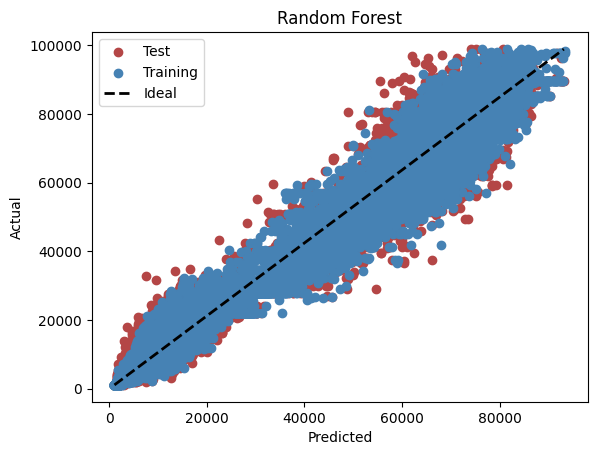

Random Forest - Test Set Evaluation Metrics:
MAPE: 0.07522934977132255
MAE : 1103.4906150908912
MSE : 6577961.889513606
RMSE: 2564.753767813512
R^2 : 0.9872457471732727


In [58]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalization using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_rf.joblib')

model = RandomForestRegressor(**rf_params)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('Random Forest')
plt.show()

# Print metrics
print("Random Forest - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# Save the model
# joblib.dump(model, 'model_rf.joblib')

**Feature Importance**

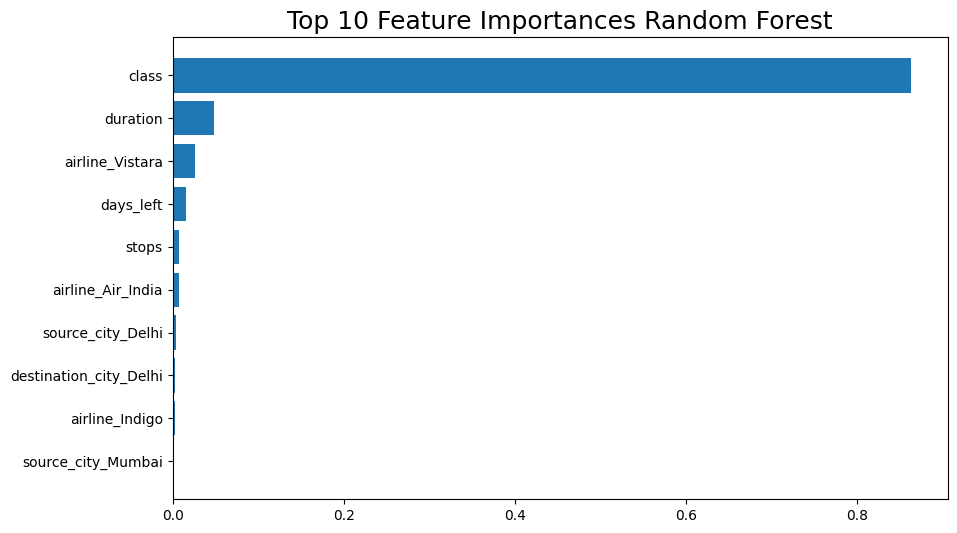

In [59]:
rf_model = joblib.load('model_rf.joblib')
feature_importance = rf_model.feature_importances_

# Get column/feature names
feature_names = x.columns  # Assuming x is your DataFrame of features

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Get top 10 feature names and importance
top_10_feature_names = feature_names[indices][:10]
top_10_feature_importance = feature_importance[indices][:10]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances Random Forest", fontsize=18)
plt.barh(top_10_feature_names, top_10_feature_importance, align="center")
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

### KNN

In [52]:
knn_params = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'weights': ['uniform'],
    'p': [1]
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
grid_knn_search = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, n_jobs=-1, verbose=2)
grid_knn_search.fit(x_train, y_train)
print('Best Params:', grid_knn_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [53]:
best_knn = grid_knn_search.best_estimator_
best_knn

KNeighborsRegressor(p=1)

In [55]:
knn_params = {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

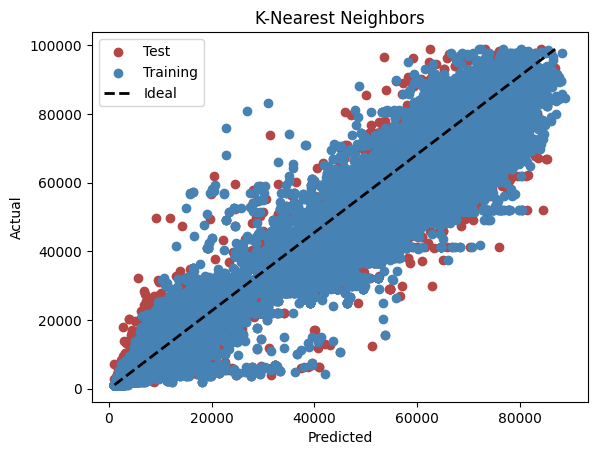

KNN - Test Set Evaluation Metrics:
MAPE: 0.11106528472113279
MAE : 1726.3161239051772
MSE : 12958418.853196038
RMSE: 3599.780389578792
R^2 : 0.9748744439289367


['model_knn.joblib']

In [56]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalization using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_knn.joblib')

model = KNeighborsRegressor(**knn_params)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('K-Nearest Neighbors')
plt.show()

# Print metrics
print("KNN - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# Save the model
# joblib.dump(model, 'model_knn.joblib')

# Predict Data

In [26]:
# Load the models
rf_model = joblib.load('model_rf.joblib')
knn_model = joblib.load('model_knn.joblib')
lr_model = joblib.load('model_lr.joblib')
poly_model = joblib.load('model_poly.joblib')

# Load the scalers and polynomial features
poly = joblib.load('poly.joblib')
scaler_lr = joblib.load('scaler_lr.joblib')
scaler_poly = joblib.load('scaler_poly.joblib')
scaler_rf = joblib.load('scaler_rf.joblib')
scaler_knn = joblib.load('scaler_knn.joblib')

# Load the feature names
feature_name = joblib.load('feature_name.joblib')

In [27]:
def transform(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [28]:
# Load dataset to predict
df_transformed = pd.read_csv('Clean_Dataset.csv')
print('Dataset Shape:', df_transformed.shape)
print('Duplicates:', df_transformed[df_transformed.duplicated()].shape[0])
df_transformed.tail()

Dataset Shape: (300153, 12)
Duplicates: 0


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


In [29]:
# Transform the data
df_transformed = transform(df_transformed)
df_transformed.tail()

,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
# Original dataset
df_ori = pd.read_csv('Clean_Dataset.csv')
print('Original Data Shape:', df_ori.shape)
df_ori.tail()

Original Data Shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


**Define Features and Target**

In [31]:
# Define features and target
x_forpred = df_transformed.drop(['Unnamed: 0', 'flight', 'price'], axis=1)
y_forpred = df_transformed['price']

x_forpred = x_forpred.reindex(columns=feature_name, fill_value=0)

### Linear Regression Prediction

In [32]:
# Scale the features
x_scaled_predict = scaler_lr.transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = lr_model.predict(x_scaled_predict)
y_baru['predicted price'] = y_predict_new

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Linear Regression - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Linear Regression - Prediction Evaluation Metrics:
# # MAPE: 0.4282044787796376
# # MSE : 46381868.57354749
# # MAE : 4515.004261160142
# # RMSE: 6810.423523801401
# # R^2 : 0.9099707967260626

Linear Regression - Prediction Evaluation Metrics:
MAPE: 0.4282044787796376
MSE : 46381868.57354749
MAE : 4515.004261160142
RMSE: 6810.423523801401
R^2 : 0.9099707967260626


In [33]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50333.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,49741.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50805.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50305.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50333.0


In [34]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_lr = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_lr['model'] = 'Linear Regression'

### Polynomial Prediction

In [35]:
# degree = 2
# poly = PolynomialFeatures(degree=degree)

In [36]:
x_scaled_predict = scaler_poly.transform(x_forpred)

x_poly_predict = poly.transform(x_scaled_predict)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = poly_model.predict(x_poly_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Polynomial Regression - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Polynomial Regression - Prediction Evaluation Metrics:
# # MAPE: 0.28050410611131166
# # MSE : 25921116.62422498
# # MAE : 3282.668988815704
# # RMSE: 5091.278486217875
# # R^2 : 0.9496859969332775

Polynomial Regression - Prediction Evaluation Metrics:
MAPE: 0.28050410611131166
MSE : 25921116.62422498
MAE : 3282.668988815704
RMSE: 5091.278486217875
R^2 : 0.9496859969332775


In [37]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56044.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53600.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54544.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,55076.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56044.0


In [38]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_poly = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_poly['model'] = 'Polynomial Regression'

### Random Forest Prediction

In [39]:
x_scaled_predict = scaler_rf.transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = rf_model.predict(x_scaled_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Random Forest - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Random Forest - Prediction Evaluation Metrics:
# # MAPE: 0.05885176456996462
# # MSE : 4509913.548031331
# # MAE : 877.828375057813
# # RMSE: 2123.6557037409175
# # R^2 : 0.9912460636871546

Random Forest - Prediction Evaluation Metrics:
MAPE: 0.05885176456996462
MSE : 4509913.548031331
MAE : 877.828375057813
RMSE: 2123.6557037409175
R^2 : 0.9912460636871546


In [40]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,75160.57
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73718.03
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77700.31
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,81284.95
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,75160.57


In [41]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_rf = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_rf['model'] = 'Random Forest'

### KNN Prediction

In [42]:
x_scaled_predict = scaler_knn.fit_transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = knn_model.predict(x_scaled_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("KNN - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # KNN - Prediction Evaluation Metrics:
# # MAPE: 0.12079696574628214
# # MSE : 17864727.80581357
# # MAE : 2010.6154801051468
# # RMSE: 4226.668641591575
# # R^2 : 0.9653237943936476

KNN - Prediction Evaluation Metrics:
MAPE: 0.12079696574628214
MSE : 17864727.80581357
MAE : 2010.6154801051468
RMSE: 4226.668641591575
R^2 : 0.9653237943936476


In [43]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64605.8
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48272.2
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57868.4
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,71124.2
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64605.8


In [44]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_knn = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_knn['model'] = 'KNeighbors'    

### Combine Results

In [45]:
# Combine all models
df_combined = pd.concat([df_combined_lr, df_combined_poly, df_combined_rf], axis=0)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (900459, 13)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,predicted price,model
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,75160.57,Random Forest
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,73718.03,Random Forest
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,77700.31,Random Forest
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,81284.95,Random Forest
300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585,75160.57,Random Forest


In [46]:
# Export the prediction results
# df_combined.to_csv('Prediction Results Final.csv', index=False)